In [1]:
from multi_arm_bandits import *
from utils import *

## Overview

This notebook explores the use of Multi Armed bandits to arrive at the most favourable design for an online experiment. Online experiment involves multiple design choice that can be shown to user to get value, this value can be revenue obtained once the user interacts an the online service. A typical example can be the design of the ad, that can make it more suitable for the users to click on the ad thereby generating revenue for the organisation. 

Typically revenue comes later in the user funnel when user make as a purchase but to understand the impact of different strategies we will assume that clicking on the ad generates a fixed revenue per user to the organization. An example of this could be Google running an A/B/n test to improve the interface for the user making it more desirable for a user to click on the ad, the event that generates revenue for every click.

Overall process of designing and evaluating an A/B test can be broadly divided into three components, that are as follows - 

**1. Design choices** 

In real world, these can be different marketing strategy for promotions that a you want to test before rolling out to the masses, or different choices of UI changes that a you want to test out to understand what choice leads to a higher engagement with the audience. In this example we will assume there are 4 different ad designs that the creative team has come up with and the management wants to run an A/B/n test to arrive at the best performing ad design that can be rolled out enterprise wide.

**2. Design selection strategy**

Design selection strategy govers what ad to display to a group of audience, this can be done in two ways - 1. Random assignment, and 2. Bandit algorithms. Random assignments allocates the traffic equally to all the possible choices during the test and once test is done, we evaluate the performance based on the KPI of concern (could be clicks or revenue). Though this is a pretty straigthforwad strategy to implement, it doesn't take into account the information obtained during the test itself to divert the audience from less desirable choices to more desirable choices. For example, let's say we have four designs that we want to test, and a total of 1 million user impressions is selected as stopping criteria (equivalent to approx 250k impressions for each design choice) for the test. In this situtation, there coould be a possibility that way before the test ends, the early performance can indicate that one of the choice performs significantly worse that the rest of choices, with random assignment there is no way that the rest of the audience of that choice can be diverted to more desirable ones, that's when Bandit algorithms come into play. With exploration-exploitation approach, bandit algorithms wait for getting the right amount of data to make a decision to cut off the audience flow to the undesirable design.

**3. Performance evaluation and Optimal Design**

The end goal of any A/B test is to understand the optimal choice by takeing feedback from users on a small scale. To arrive at the optimal design choice at the end of test, one looks at KPI or a set of KPIs, also called goal metrics, that the you want to drive and evaluate which choice gives the most impact. The most common way of doing this to perform hypothesis testing, assume that all choice affect the goal metrics similarly and there is no statistical difference in all the design choice and this will be the null hypothesis. Based on the observed data during the test, distribution of goal metrics can be emprically obtained to reject the null hypothesis and optimal design choice can be selected as the one with best performing goal metric.


*Note: Designing and evaluating an A/B test is not that easy in real world, there are a lot of considerations that need to be taken and continuous monitoring of the test is done to avoid driving spurious and incorrect conclusion in the end. For the sake of simiplicity, in this simulation exercise we will focus only on bandit algorithm for experimental design and not address the real world challenges.*

## Bandit algorithms

Multi-arm bandit problem refers to problem space where there are a bunch of possible choices and a decision need to taken (either once or multiplie time) to maximize some reward despite not knowing what the reward distribution of each choices looks like, these kinds of problem are solved with some exploration-exploitation approach where initially exploration is done to get some idea about the reward pattern of each choices and once enough information is obtained the best choice is exploiting more frequently with still some exploration to ensure the right choice is being exploited.

In this section, we will talk about some of the common bandit algorithms with a brief description of how they work. Other than random assignment we will consider 4 different bandit algorithm to dynamically allocate traffic to different design choices during the experiment. Theoretical evaluation of these algorithm is already available in literature, where regret bounds of different bandits algorithm are evaluated analytically (regret being the lost opportunity in the absence of knowledge about the optimal choice). For this simulation, we will evaluate bandit algorithms by empirically calculating regret since the goal metric's distribution of each design choice will be known but hidden to algorithms during the test.

Multi arm bandit terminology from ad selection experiment - 
* trial - showing up an ad to the user
* arm - design choices considered during experimentation
* reward - goal metrics, click through rate

**Epsilon-greedy**

Epsilon-greedy approach explicitly tends to balance between exploration and exploitation during a trial based on a probability factor $\epsilon$. Assume that for each trial a hypothetical coin, that has a probability $\epsilon$ of getting head, will be tossed, everytime head comes the arm will be choosen at random (exploration) but if tails come up then the arm with highest mean reward will be selected. With a fixed $\epsilon$, at any point in time in the experiment, exploration will be fixed, but that might not be the most optimal approach, since at the beginning of the experiment we would want to explore more to get information about the rewards but as we progress we can have enough data to ascertain the best arm, thereby reducing the need for exploration. To tackle this behaviour during the test, annealing can be used where the parameter $\epsilon$ will be a function of time, starting with a high number and gradually reducing as more and more information gets available.


**UCB**

UCB, short for, Upper confidence bound, is another approach for adaptive exploration known as optimism under uncertainty, that manages exploration vs exploitation dilemma by setting the upper uncertainity bounds on each action taken in the past. Consider that after $T$ trails, every action possible (arm pull) $a_{i}$ is selected $N_{i}$ times and average reward $Q_{T, i}$ obtained whenever an action is selected in the past, using this information an upper bound on reward can be estimated. The goal is to always select the arm that has the highest upper condidence bound, that gets updated after the action is taken and outcome is known. Though for the start of the experiment, each arm will be selected randomly $k$ times to have enough information to estimate the upper bound. As the experiment continues, for every trial, the upper confidence bound of the selected arm $a_{i}$ will be updated based on the reward obtained. After a period of time, the arms that constantly underperforms will have reduced probabity of getting selected ensuring the best possible action is taken given the information available. 


**Thompson sampling**

Compared to other multi arm bandit approaches described above, where either the mean reward or upper bound on reward is used as a criteria to select the best arm for a trial, Thompson sampling creates a distribution and samples from the distribution to identify the best arm. Also, for every trial, the distribution of selected arm is updated based on observed reward. For a bernoulli bandit case, such as ours where the reward is binary (either a click is observed or not after the arm selection), a beta distribution is assumed as the prior and the parameters of the distribution are updated as an arm is selected and reward is observed with a prior of each arm having the same and an equal likelihood of getting a click. Assuming a beta distribution simplifies the calculation as beta distribution is its own conjugate prior, hence after each trial the prior and posterior distribution family is same and only the parameters $a$ and $b$ needs to be changed.

Beta distribution - $\frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)}x^{a - 1}(1 - x)^{b - 1}$

For an arm selected @ t, parameter updated for arm $a_{i}$ will be based on $r_{t, i}$ - if $r_{t, i}$ = 1, $a = a + 1$, else $b = b + 1$

The parameters, $a$ and $b$ can be though of number of times the trial is won (click is observed) and lost (click is not observe) respectively


## Simulation Design

To understand the efficacy of the above mentioned multi arm bandit approaches, simulation will be setup where the true reward distribution of each arm will be defined so that exact regret or opportunity loss due to not knowing the best action can be calculated.

*Environment setup*
1. Arms or design choices - Defining the choices of ad designs (that will be later referred to as arms) with reward (click through rate and revenue) unknown
2. Bandit algorithms - 
    * $\epsilon$ greedy with linear annealing
    * UCB
    * Thompson sampling
    
*Stopping criteria* - After the specified number of trails are completed

*Evaluation*
1. Cumulative total regret for the complete test duration
2. Optimal arm selection percentage
3. Incremental clicks compared to baseline (random assignment)

*Assumptions*
1. Uniform (stratified audience)
2. Ad selection only depends on the choice presented to the user
3. No temporal change in user behaviour when the experiment is running


## Simulation

### Design choices (Arms)

Lets assume there are 4 different choices of ad that can be shown to the user, these ads will have inherent reward -> click through probability $p_{i}$ that will be know by design but will be unknown during the experiment. For setting up a limit to the length of online experiment it is assumed that the experiment will terminate after ads are shown 10,000 times.

In [2]:
# assuming fixed but unknown ctr distribution of the the design choices
n_arms, n_trials = 4, 10000
np.random.seed(40)
ctr_list = [0.02, 0.03, 0.04, 0.044]
arms_list = ArmsList(n_arms=n_arms, p_arms=ctr_list)
arms_list.get_best_arm().mu

0.044

### Random Assignment

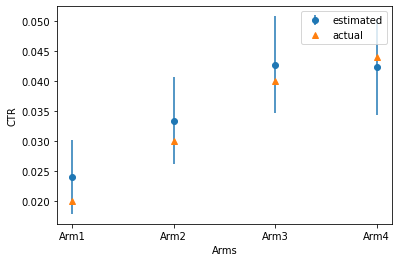

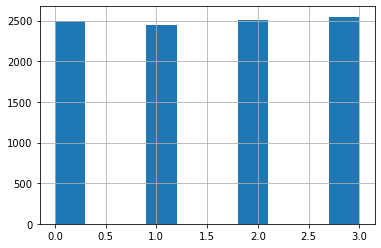

In [3]:
random_assignment = RandomAssignment(n_arms, 10000)
random_assignment_reward = random_assignment.run_test(arms_list)

plot_rewards(arms_list, random_assignment_reward)
random_assignment.plot_arms_distribution()

### $\epsilon$ greedy

**10,000 trials distributed over the 4 design choices, with linear annealing starting from 100th trial**

In [4]:
eps_greedy = EpsGreedy(n_arms, 10000, 0.05, 100)
eps_greedy_reward = eps_greedy.run_test(arms_list)

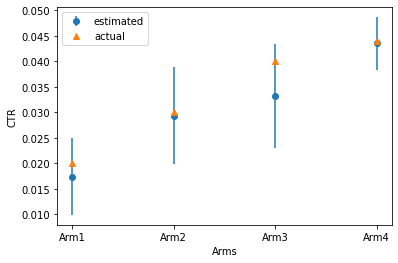

In [5]:
plot_rewards(arms_list, eps_greedy_reward)

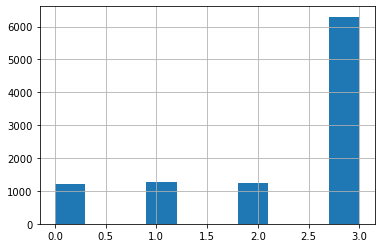

In [6]:
eps_greedy.plot_arms_distribution()

### UCB

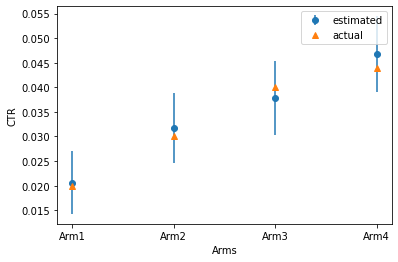

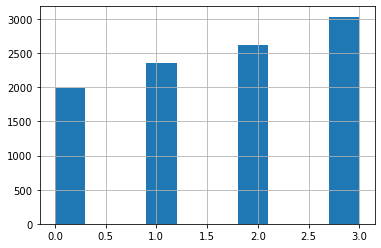

In [7]:
ucb = UCB(n_arms, 10000, 0.95, 100)
ucb_reward = ucb.run_test(arms_list)

plot_rewards(arms_list, ucb_reward)

ucb.plot_arms_distribution()

### Thompson sampling

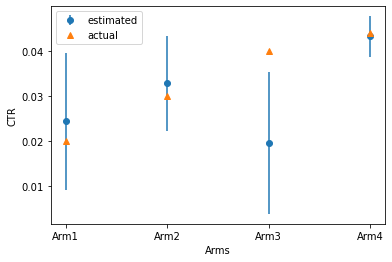

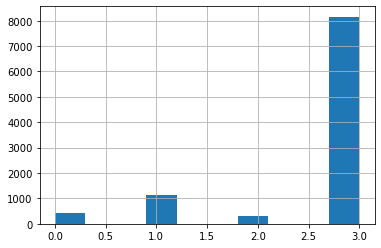

In [8]:
ts = ThompsonSampling(n_arms, 10000)
ts_reward = ts.run_test(arms_list)

plot_rewards(arms_list, ts_reward)

ts.plot_arms_distribution()

## Comparitive analysis

* Where do we get the least regret (clicks that could have been obtained if the best arm is known)?
* Which algorithm gives us the highest total reward (clicks) by the end of the trial?
* Which algorithm is able to pick the optimal arm the most?

### Regret

One of the most common ways to evaluate the performance of an Multiarm bandit algorithm is by comparing the algorithm's mean reward to the best-arm benchmark, defined as regret. Note this can't be done in practice as the best arm will be never be known in real world cases. Numerically regret is defined as below - 

$$\mathop{\mathbb{E}} [R] = \mu^{*} - 1/ T \sum_{t} r_{t}$$

In the online experimentation case regret can be interpreted as the average clicks per trial lost as the best arm is not known to the algorithm

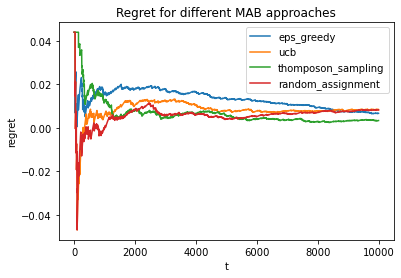

In [9]:
# regret plots
mab_list = {
    'eps_greedy': eps_greedy,
    'ucb': ucb,
    'thomposon_sampling': ts,
    'random_assignment': random_assignment
}

plot_regret(arms_list, mab_list)

*Note- the negative regret is not indicative that the algorithm is doing better than the best possible arm, instead, for the first few trial the realization of a click is coming early that makes the algorithms rewards highest than the mean optimal reward*

### Clicks received

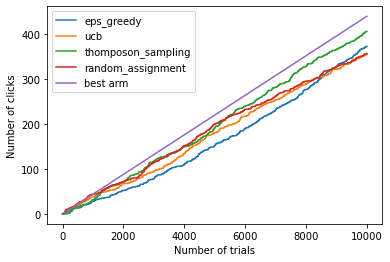

In [10]:
plot_clicks_received(n_trials, mab_list, arms_list)

In [11]:
for mab_name, mab in mab_list.items():
    print(' # of clicks observed for ', mab_name, np.sum(mab.observed_rewards))

 # of clicks observed for  eps_greedy 373
 # of clicks observed for  ucb 357
 # of clicks observed for  thomposon_sampling 406
 # of clicks observed for  random_assignment 357


### Optimal arm selection percentage

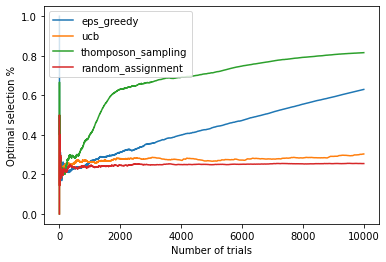

In [12]:
plot_optimal_arm_selection(n_trials, mab_list, arms_list)

## Conclusion

Compared to statistical AB testing, where the traffic is distributed equally across different candidates, MAB algorithms explores a lot, initially, to ascertain the best candidate and keep on use the candidate to further ensure that its the best arm. The intensity of exploration is high in the beginning but paves the path to exploitation as more and more data is observed. Contrary to MAB, statistical AB testing approach solely relies on exploration, and wait for the the test to end to decide the best candidate, this can lead to loss in reward, that could have been obtained if not for complete exploration. Though the benifit of statistical AB testing is that, it can theoritically ensure that the best after after the trail is indeed the best arm with statistical significant. Though in real life cases even with pure exploration the statistical significant can't be obtained. 

Among the different MAB algorithms, Thompson sampling does the best in terms of minimizing the regret followed by $\epsilon$-greedy and then UCB. Another aspect to note here is that, both $\epsilon$-greedy and UCB have hyperparameter in it, that needs to be selected before the test is started and the performance of those two algorithm is highly affected by the selected hyperparameters, though Thompson sampling will perform the same as it doesn't need require a hyperparameter. 





## References - 
* Multi-armed bandit experiments in the online service economy https://onlinelibrary.wiley.com/doi/abs/10.1002/asmb.2104
* Interface Design Optimization as a Multi-Armed Bandit Problem https://dl.acm.org/doi/10.1145/2858036.2858425 
* https://towardsdatascience.com/beyond-a-b-testing-multi-armed-bandit-experiments-1493f709f804
* https://analytics.googleblog.com/2013/01/multi-armed-bandit-experiments.html